# TFServing on SageMaker

## 0. Create model artifacts w/ `inference.py`

In [1]:
%%writefile code/inference.py
######################################################################################################
# https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/deploying_tensorflow_serving.html
######################################################################################################

import json

def input_handler(data, context):
    """ Pre-process request input before it is sent to TensorFlow Serving REST API
    Args:
        data (obj): the request data, in format of dict or string
        context (Context): an object containing request and configuration details
    Returns:
        (dict): a JSON-serializable dict that contains request body and headers
    """
    if context.request_content_type == 'application/json':
        print('Start inference.........')
        # pass through json (assumes it's correctly formed)
        d = data.read().decode('utf-8')
        return d if len(d) else ''

    if context.request_content_type == 'text/csv':
        # very simple csv handler
        return json.dumps({
            'instances': [float(x) for x in data.read().decode('utf-8').split(',')]
        })

    raise ValueError('{{"error": "unsupported content type {}"}}'.format(
        context.request_content_type or "unknown"))


def output_handler(data, context):
    """Post-process TensorFlow Serving output before it is returned to the client.
    Args:
        data (obj): the TensorFlow serving response
        context (Context): an object containing request and configuration details
    Returns:
        (bytes, string): data to return to client, response content type
    """
    if data.status_code != 200:
        raise ValueError(data.content.decode('utf-8'))

    response_content_type = context.accept_header
    prediction = data.content
    return prediction, response_content_type

Overwriting code/inference.py


### SavedModel의 input/output 확인

In [2]:
!saved_model_cli show --dir model/1 --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['conv2d_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_conv2d_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Defined Functions:
  Function Name: '__

In [3]:
!tar -cvzf model.tar.gz code --directory=model 1
# !tar -cvzf model.tar.gz --directory=model 1

code/
code/inference.py
1/
1/saved_model.pb
1/variables/
1/variables/variables.data-00000-of-00001
1/variables/variables.index


In [4]:
import sagemaker
from sagemaker import get_execution_role

session = sagemaker.Session()

bucket = session.default_bucket()
prefix = 'sinjoonk/tfserving-sm'

role = get_execution_role()

sm_model = 's3://{}/{}/model/model.tar.gz'.format(bucket, prefix)
sm_model

's3://sagemaker-us-east-1-889750940888/sinjoonk/tfserving-sm/model/model.tar.gz'

In [5]:
!aws s3 cp ./model.tar.gz {sm_model}

upload: ./model.tar.gz to s3://sagemaker-us-east-1-889750940888/sinjoonk/tfserving-sm/model/model.tar.gz


## 1. Create Tensorflow model object
https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html?highlight=create%20model%20tensorflow#sagemaker.tensorflow.model.TensorFlowModel

In [6]:
from sagemaker.tensorflow.model import TensorFlowModel

In [7]:
tf_model = TensorFlowModel(
    model_data = sm_model,
    framework_version='2.0.0',
    role=role,
)

## 2. Create Local endpoint using SM model

In [8]:
local_ep = tf_model.deploy(
    instance_type = 'local',
    initial_instance_count = 1,
)

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Attaching to bavb5sf870-algo-1-9iu8b
bavb5sf870-algo-1-9iu8b | INFO:__main__:starting services
bavb5sf870-algo-1-9iu8b | INFO:__main__:using default model name: model
bavb5sf870-algo-1-9iu8b | INFO:__main__:tensorflow serving model config: 
bavb5sf870-algo-1-9iu8b | model_config_list: {
bavb5sf870-algo-1-9iu8b |   config: {
bavb5sf870-algo-1-9iu8b |     name: "model",
bavb5sf870-algo-1-9iu8b |     base_path: "/opt/ml/model",
bavb5sf870-algo-1-9iu8b |     model_platform: "tensorflow"
bavb5sf870-algo-1-9iu8b |   }
bavb5sf870-algo-1-9iu8b | }
bavb5sf870-algo-1-9iu8b | 
bavb5sf870-algo-1-9iu8b | 
bavb5sf870-algo-1-9iu8b | INFO:__main__:nginx config: 
bavb5sf870-algo-1-9iu8b | load_module modules/ngx_http_js_module.so;
bavb5sf870-algo-1-9iu8b | 
bavb5sf870-algo-1-9iu8b | worker_processes auto;
bavb5sf870-algo-1-9iu8b | daemon off;
bavb5sf870-algo-1-9iu8b | pid /tmp/nginx.pid;
bavb5sf870-algo-1-9iu8b | error_log  /dev/stderr error;
bavb5sf870-algo-1-9iu8b | 
bavb5sf870-algo-1-9iu8b | worker_

## 3. Local inference

In [9]:
import tensorflow as tf
import matplotlib.pylab as plt

import requests
import json

fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [10]:
labels = {'0': 'T-shirt/top',
          '1': 'Trouser',
          '2': 'Pullover',
          '3': 'Dress',
          '4': 'Coat',
          '5': 'Sandal',
          '6': 'Shirt',
          '7': 'Sneaker',
          '8': 'Bag',
          '9': 'Ankle boot'}

In [11]:
def fashion_mnist_show(n):
    image = test_images[n]
    image_reshaped = image.reshape(28, 28)
    label = labels[str(test_labels[n])]
    plt.figure(figsize = (2, 2))
    plt.title("sample of " + str(label))
    plt.imshow(image_reshaped, cmap="gray")
    plt.show()

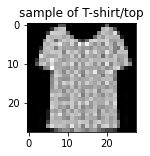

In [12]:
fashion_mnist_show(1000)

### curl + POST로 추론 요청: Not working (SigV4 인증 필요)

In [13]:
def fashion_mnist_inference(n):
    image = test_images[n]
    image = image.reshape(-1, 28, 28, 1)
    headers = {"content-type": "application/json"}
    payload = json.dumps({"signature_name": "serving_default",
                          "instances": image.tolist()})
    response = requests.post('http://localhost:8501/v1/models/mnist:predict',
                              data=payload, headers=headers)
    return response.json()

In [14]:
# fashion_mnist_inference(100) # ConnectionRefusedError

### endpoint.predict 사용

In [15]:
image = test_images[100]             # ndarray
image = image.reshape(-1, 28, 28, 1) # ndarray
payload = {"signature_name": "serving_default",
           "instances": image.tolist()}

local_ep.predict(payload)            # Working

bavb5sf870-algo-1-9iu8b | Start inference.........


{'predictions': [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]}

bavb5sf870-algo-1-9iu8b | 172.18.0.1 - - [10/Jan/2022:13:12:51 +0000] "POST /invocations HTTP/1.1" 200 80 "-" "python-urllib3/1.26.7"


In [16]:
!docker kill $(docker ps -q)

bavb5sf870-algo-1-9iu8b exited with code 137
4755483a9852
Aborting on container exit...


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sagemaker/local/image.py", line 837, in run
    _stream_output(self.process)
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sagemaker/local/image.py", line 899, in _stream_output
    raise RuntimeError("Process exited with code: %s" % exit_code)
RuntimeError: Process exited with code: 137

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sagemaker/local/image.py", line 842, in run
    raise RuntimeError(msg)
RuntimeError: Failed to run: ['docker-compose', '-f', '/tmp/tmp_7su_62f/docker-compose.yaml', 'up', '--build', '--abort-on-container-exit'], 

## 4. Create SM endpoint using SM model

In [17]:
tf_model = TensorFlowModel(
    model_data = sm_model,
    framework_version='2.0.0',
    role=role,
)

In [18]:
sm_ep = tf_model.deploy(
    instance_type = 'ml.m5.xlarge',
    initial_instance_count = 1,
)

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


----!

In [19]:
sm_ep.endpoint_name

'tensorflow-inference-2022-01-10-13-13-02-960'

### Inference by `invoke_endpoint`
https://docs.aws.amazon.com/sagemaker/latest/dg/neo-requests-boto3.html

In [20]:
image = test_images[100]             # ndarray
image = image.reshape(-1, 28, 28, 1) # ndarray
payload = {"signature_name": "serving_default",
           "instances": image.tolist()}

In [21]:
import boto3
sm_runtime = boto3.client('sagemaker-runtime')

response = sm_runtime.invoke_endpoint(
    EndpointName=sm_ep.endpoint_name,
    Body=json.dumps(payload),
    ContentType='application/json'
)

result = json.loads(response['Body'].read().decode())
result

{'predictions': [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]}

## 5. Cleanup

In [ ]:
sm_ep.delete_endpoint()

# Serverless Inference (Preview)

### 1. Create model

In [28]:
#Setup
import boto3
import sagemaker
region = boto3.Session().region_name
client = boto3.client("sagemaker", region_name=region)

#Role to give SageMaker permission to access AWS services.
sagemaker_role = sagemaker.get_execution_role()

#Get model from S3
model_url = sm_model

In [29]:
from sagemaker import image_uris
container = image_uris.retrieve(
    framework = 'tensorflow',
    region = region,
    version = '2.0.0',
    py_version = 'py3',
    image_scope = 'inference',
    instance_type='ml.m5.xlarge'
)
container

'763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference:2.0.0-cpu'

In [33]:
#Create model
model_name = "serverless-inference-model"

response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = sagemaker_role,
    Containers = [{
        "Image": container,
        "Mode": "SingleModel",
        "ModelDataUrl": model_url,
    }]
)

response

{'ModelArn': 'arn:aws:sagemaker:us-east-1:889750940888:model/serverless-inference-model',
 'ResponseMetadata': {'RequestId': '310a29ef-bd8c-419c-a44e-d78a87a9de7d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '310a29ef-bd8c-419c-a44e-d78a87a9de7d',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '88',
   'date': 'Mon, 10 Jan 2022 13:21:54 GMT'},
  'RetryAttempts': 0}}

## 2. Create Endpoint configuration

In [34]:
response = client.create_endpoint_config(
   EndpointConfigName="serverless-inference-model-epc",
   ProductionVariants=[
        {
            "ModelName": "serverless-inference-model",
            "VariantName": "AllTraffic",
            "ServerlessConfig": {
                "MemorySizeInMB": 2048,
                "MaxConcurrency": 20
            }
        } 
    ]
)

response

{'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:889750940888:endpoint-config/serverless-inference-model-epc',
 'ResponseMetadata': {'RequestId': '78d9e3b9-5b2a-43e7-a926-a634d38ac835',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '78d9e3b9-5b2a-43e7-a926-a634d38ac835',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '111',
   'date': 'Mon, 10 Jan 2022 13:22:21 GMT'},
  'RetryAttempts': 0}}

## 3. Create Endpoint

In [35]:
response = client.create_endpoint(
    EndpointName="serverless-inference-model-ep",
    EndpointConfigName="serverless-inference-model-epc"
)

response

## Invoke Endpoint

In [37]:
image = test_images[100]             # ndarray
image = image.reshape(-1, 28, 28, 1) # ndarray
payload = {"signature_name": "serving_default",
           "instances": image.tolist()}

#### Slow response due to cold start

In [38]:
%%time
import boto3
sm_runtime = boto3.client('sagemaker-runtime')

response = sm_runtime.invoke_endpoint(
    EndpointName="serverless-inference-model-ep",
    Body=json.dumps(payload),
    ContentType='application/json'
)

result = json.loads(response['Body'].read().decode())
result

CPU times: user 6.85 ms, sys: 8.29 ms, total: 15.1 ms
Wall time: 2.58 s


{'predictions': [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]}

#### Fast response after 2nd invocation

In [39]:
%%time
import boto3
sm_runtime = boto3.client('sagemaker-runtime')

response = sm_runtime.invoke_endpoint(
    EndpointName="serverless-inference-model-ep",
    Body=json.dumps(payload),
    ContentType='application/json'
)

result = json.loads(response['Body'].read().decode())
result

CPU times: user 15.1 ms, sys: 0 ns, total: 15.1 ms
Wall time: 267 ms


{'predictions': [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]}

In [40]:
%%time
import boto3
sm_runtime = boto3.client('sagemaker-runtime')

response = sm_runtime.invoke_endpoint(
    EndpointName="serverless-inference-model-ep",
    Body=json.dumps(payload),
    ContentType='application/json'
)

result = json.loads(response['Body'].read().decode())
result

CPU times: user 14.7 ms, sys: 0 ns, total: 14.7 ms
Wall time: 175 ms


{'predictions': [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]}